In [1]:
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const


### This tutorial shows how to create the $K_{p}-v_{sys}$ Map from the Cross-Correlation functions

We will use the data from the previous tutorial. The idea is to shift the data into the rest frame of the planet and summing over time (weighted on the transit). Because we do not know the exact value of $K_p$ normally, we will do this over a range of values. Remember that for real data, we may not yet be able to see the exoplanet's signal. But first, we'll show that for a given value of $K_p$, we can Doppler shift the dataset back to the rest frame of the planet.

A couple of important things to note:
The x-axis of the data is now in velocity ($v_{sys}$), so Doppler shifts can be done by adding a constant to $v_{sys}$. Note the sign is reversed to before so the shift is reversed.

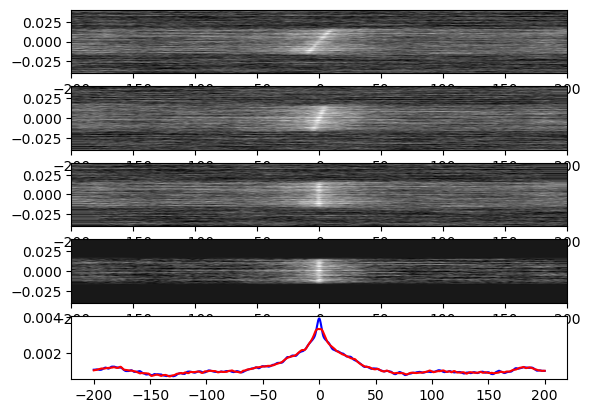

In [2]:

#let's reload the CC funcs from the previous tutorial
D = np.load('CC_funcs.npz')
CC = D['CC'] 
CC_faint = D['CC_faint'] 
v_sys = D['v_sys'] 
ph = D['ph'] 
tmodel = D['tmodel'] 

#get transit weighting from model
tweight = (1. - tmodel) / np.ptp(tmodel)

k = 50 #for now, assumed value of Kp 

#compute the velocity as a function of time for specific Kp
vp = k*np.sin(ph*2.*np.pi)

#create empty array to store Doppler-shifted CC function
CC_shifted = np.empty(CC.shape)

for i,vel in enumerate(vp): #loop over velocities and interpolate to planet's rest frame assuming given Kp
  CC_shifted[i] = np.interp(v_sys+vel,v_sys,CC[i])

f,a = plt.subplots(5)
a[0].pcolormesh(v_sys,ph,CC)
a[1].pcolormesh(v_sys,ph,CC_shifted)

#Let's also try it for the 'correct' Kp
k = 100
vp = k*np.sin(ph*2.*np.pi)
CC_shifted_corr = np.empty(CC.shape)
for i,vel in enumerate(vp): #loop over velocities and interpolate to planet's rest frame assuming given Kp
  CC_shifted_corr[i] = np.interp(v_sys+vel,v_sys,CC[i])
a[2].pcolormesh(v_sys,ph,CC_shifted_corr)

#finally we want to sum the signal over time, in order to boost the signal further
#note that we first want to weight by the transit function
a[3].pcolormesh(v_sys,ph,CC_shifted_corr * tweight[:,None])
#perform the sum over time (axis=0)
cc_sum = np.sum(CC_shifted_corr * tweight[:,None], axis=0)
a[4].plot(v_sys,cc_sum,'b-') # and plot

#We can also do the sum over the incorrect kp
cc_sum = np.sum(CC_shifted * tweight[:,None], axis=0)
a[4].plot(v_sys,cc_sum,'r-') # and plot


Note that there is still some signal where the $K_p$ is not the nominal value. This is because we have injected a very strong signal, and summing over the 'wrong' $K_p$ can still give a peak in the summed CC, only with reduced amplitude and slightly broader.

*Also note that we cannot perform the interpolation in one line of code, as we are intpolating different data each time rather than a single template.*

Now we want to do this procedure for a range of $K_p$ values.


Text(0, 0.5, '$K_{p}$')

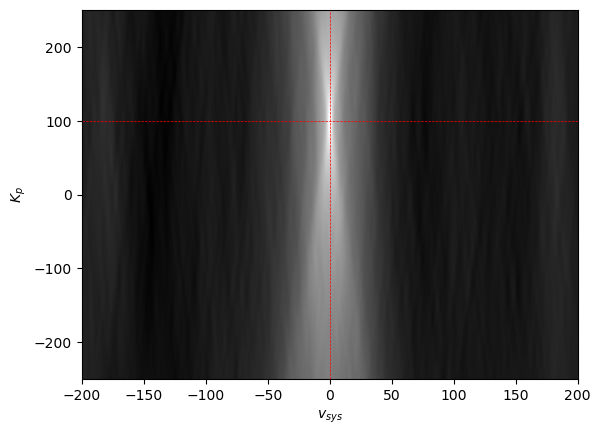

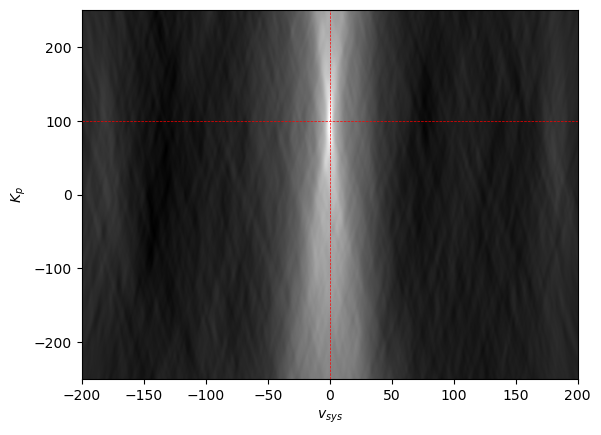

In [3]:
#define range of Kps
K = np.linspace(-250,250,600) #km/s

#create empty array to store Doppler-shifted CC function (same shape as CC)
CC_shifted = np.empty(CC.shape)

#define array to store Kp-v_sys map - one dimension will be for Kp, the other is still v_sys (as we are summing CC funcs over time)
CC_map = np.empty((K.size,v_sys.size))

#loop over the Ks
for i in range(K.size):
  vp = K[i]*np.sin(2.*np.pi*ph) #compute planet's vel as a func of time for each Kp
  
  for j in range(vp.size): #loop over velocities and interpolate to planet's rest frame assuming given Kp
    CC_shifted[j] = np.interp(v_sys+vp[j],v_sys,CC[j])
  
  #store *weighted* sum for each Kp - is sum in time but weighted on the transit function
  CC_map[i] = np.sum(CC_shifted * tweight[:,None], axis=0)
  #CC_map[i] = np.dot(CC_shifted.T,tweight) #or use dot product
    
#plot up the Kp-vys map
# we know from the injection test where the max signal should be (marked with dotted lines)
f,a = plt.subplots(1)
a.pcolormesh(v_sys,K,CC_map)
a.axhline(100,color='r',ls='--',lw=0.5)
a.axvline(0,color='r',ls='--',lw=0.5)
a.set_xlabel(r'$v_{sys}$')
a.set_ylabel(r'$K_{p}$')

#let's define a simple function to do this procedure
def vel_sum(v_sys,CC,K,tweight=None):
  
  if tweight is not None: #by default weight everything equally
    tweight = np.ones(CC.shape[0])   
  
  #define arrays for storage
  shifted = np.empty(CC.shape)
  CC_map = np.empty((K.size,v_sys.size))

  #loop over the Ks
  for i in range(K.size):
    vp = K[i]*np.sin(ph*2.*np.pi) #compute vp for each K
    for j in range(vp.size): #loop over velocities and interpolate to planet's rest frame assuming given Kp
      shifted[j] = np.interp(v_sys+vp[j],v_sys,CC[j])

    #store weighted sum for each Kp
    CC_map[i] = np.sum(shifted * tweight[:,None], axis=0)
  
  return CC_map

#test the function
CC_map = vel_sum(v_sys,CC,K,tweight=tweight)
f,a = plt.subplots(1)
a.pcolormesh(v_sys,K,CC_map)
a.axhline(100,color='r',ls='--',lw=0.5)
a.axvline(0,color='r',ls='--',lw=0.5)
a.set_xlabel(r'$v_{sys}$')
a.set_ylabel(r'$K_{p}$')

Finally, let's go back to the 'faint' signal. Note that we cannot see the planet's signal in the phase-cc map, only in summed $K_p-v_{sys}$ map!

We'll also now try and set a simplistic detection significance, by dividing the $K_p-v_{sys}$ map through by its standard deviation. To do this we must take care to avoid the true signal at $v_{sys}$ = 0 and $K_p$ = 100. Once we divide through by stdev, we can intrepret the value as the detection significance, or deviation from the mean in terms of standard deviation. Keep in mind that for a Gaussian distribution, ~68% of the data should be *within* $\pm$1$\,\sigma$, and ~99.9% should be *less* than 3$\,\sigma$, e.g.:

```
> import scipy.stats
> scipy.stats.distributions.norm.cdf([-1,1.]).ptp()
> scipy.stats.distributions.norm.cdf([3.])
```

Sometimes we also need to first subtract the mean of the map (after filtering out the signal). This depends on how the noramisation is done during the cross-correlation process. Generally, the background of your map should be at zero signal, plus/minus roughly 3-4 $\,\sigma$.



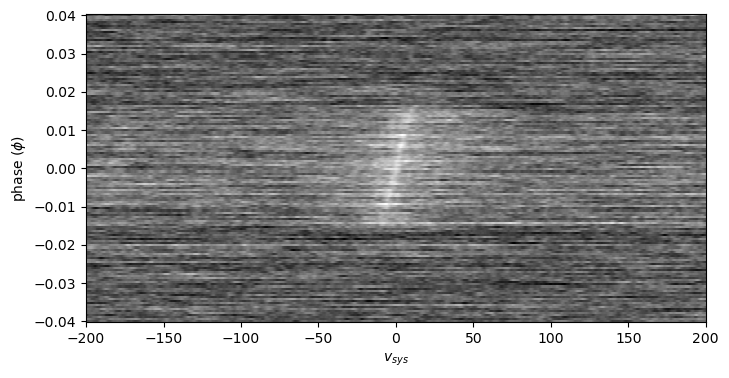

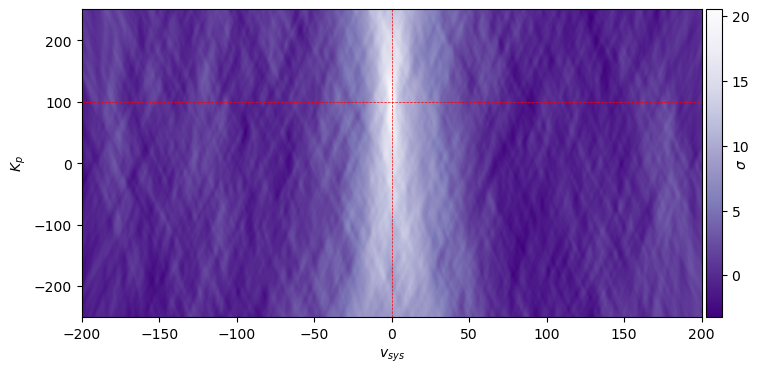

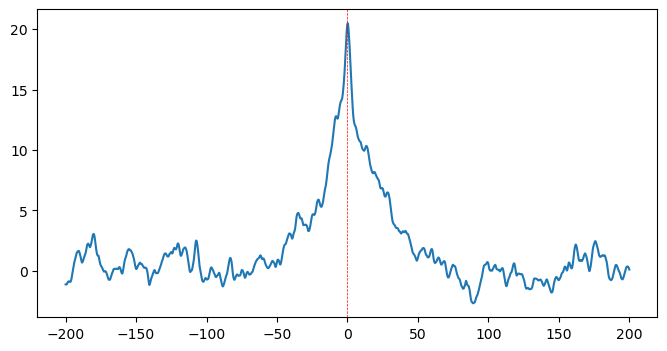

In [4]:

#get the CC map and plot
CC_map = vel_sum(v_sys,CC_faint,K,tweight=tweight)

#find the standard deviation of the map away from the signal
sl = [v_sys.size//8,v_sys.size//8*3,v_sys.size//8*5,v_sys.size//8*7]
# ind_v_sys = (v_sys < -50) + (v_sys > 50) #get a filter over v_sys
# stdev = CC_map[K.size//2,ind_v_sys].std() #find the filted stdev (only taking positive Kps?)
mean = CC_map[:,sl[0]:sl[1]].mean()/2. + CC_map[:,sl[2]:sl[3]].mean()/2.
stdev = CC_map[:,sl[0]:sl[1]].std()/2. + CC_map[:,sl[2]:sl[3]].std()/2.

f,a = plt.subplots(1,figsize=(8,4))
a.pcolormesh(v_sys,ph,CC_faint)
a.set_xlabel(r'$v_{sys}$')
a.set_ylabel(r'phase ($\phi$)')
#a[0].colorbar

f,a = plt.subplots(1,figsize=(8,4))
# for colorbars see https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
# or plt.colormaps() to print available ones
q = a.pcolormesh(v_sys,K,(CC_map-mean)/stdev,rasterized=True,cmap='Purples_r')
a.set_xlabel(r'$v_{sys}$')
a.set_ylabel(r'$K_{p}$')
a.axhline(100,color='r',ls='--',lw=0.5)
a.axvline(0,color='r',ls='--',lw=0.5)

#create colorbar - a little awkward to get in the right position
ax_position = list(a.get_position().bounds)
ax_position[0] = ax_position[0] + ax_position[2] + 0.005
ax_position[2] = 0.02
cb_axis = f.add_axes(ax_position)
cb = plt.colorbar(q,cax=cb_axis)
cb_axis.set_ylabel(r'$\sigma$',labelpad=-10)
#cb.set_ticks([-3,0,3,6,9])

#plot a slice through the max Kp - np.argmin(np.abs(K-100)) gives index to nearest value to 100
f,a = plt.subplots(1,figsize=(8,4))
plt.plot(v_sys,((CC_map-mean)/stdev)[np.argmin(np.abs(K-100))])
plt.axvline(0,color='r',ls='--',lw=0.5)


We now have a $K_p-v_{sys}$ map that looks something like that in the paper. These are basic techniques used in order to discover spectroscopic features in exoplanet atmospheres! The key things are to get a model that is reasonably accurate as a template, and also to pre-process your data so we get something like the simulation here. This requires us to align the spectra, and remove the stellar and telluric signals, which a differenet set of tutorials will look at.